<center> <big> <b> Customer segmentation <b> <big>  <center>


In this project, we solve a marketing problem. We segment the customers based on their purchasing power, frequency of the orders and recency of the last one, and determine the best strategy for interacting with them.

Marketing is an essential part of any business. It's important to understand your customer, their needs and preferences in order to increase the profits. As e-commerce has gained popularity, it has become much easier to collect customer data, analyze it, find patterns, and implement marketing campaigns. Machine learning is able to enchance these data and deepen knowledge in customer behavior. Machine learning can provide information on professional customer behavior patterns, identify customer categories (e.g., loyal/prospective/newcomer/sleeper/retired) and choose the right strategy to interact with them.

**Business objective:** to segment the existing customers, interpret those segments, and define a strategy for interacting with them.

**Technical challenge:** construct a model for clustering customers based on their purchasing power, frequency, and recency of last purchase, and define a profile for each cluster.

**Main steps of the project:**
1. Preprocess data.
2. Perform EDA and identify key patterns.
3. Form product and customer categories. 
4. Build several machine learning models to solve the problem clustering, determine the number of clusters and interpreting them.
5. Design a process for predicting customer interest categories and test your model on new customers.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

# Preprocessing

In [2]:
data = pd.read_csv(
    "customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(1)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


We have data on more than 0.5M transactions. Each of them is described by the following attributes:

* InvoiceNo - Invoice number (a unique nominal six-digit number assigned to each transaction; the letter "C" at the beginning of the code indicates a cancellation of the transaction);
* Stock Code - product code (a unique five-digit integer number assigned to each individual product);
* Description - the name of the item;
* Quantity - quantity of each item per transaction; 
* InvoiceDate - date and time of the invoice/transaction;
* UnitPrice - price per item unit in pounds;
* CustomerID - the customer's identifier (a unique five-digit number, uniquely assigned to each client);
* Country - the name of the country the customer lives in.

In [4]:
# Check how many missing values there are
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Gaps in the customer ID and item description column indicate incorrect/incomplete transactions. Therefore, we drop all these obs..

In [5]:
# Check how many missing values in total 
print("The are {} missing values".format(data.isna().sum().sum()))
# Drop all the rows with missings
data.dropna(inplace=True)
print("After dropping all the missing values, there are {} obsevations left".format(data.shape[0]))


The are 136534 missing values
After dropping all the missing values, there are 406829 obsevations left


In [6]:
# Check for duplicates

# Check for duplicates
print("The are {} missing values".format(data.duplicated().sum()))
# Drop all the rows with missings

data.drop_duplicates(inplace = True)
print("After dropping all the duplicates, there are {} obsevations left".format(data.shape[0]))


The are 5225 missing values
After dropping all the duplicates, there are 401604 obsevations left


In [7]:
# Change the date factor to date format.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Observation period is ', data['InvoiceDate'].min(), " - ", data['InvoiceDate'].max())

Observation period is  2010-12-01 08:26:00  -  2011-12-09 12:50:00


In [8]:
display(data.describe(include='object').transpose())
print("No of unique customers is {}".format(len(data['CustomerID'].unique())))
print("No of unique countries is {}".format(len(data['Country'].unique())))


,count,unique,top,freq
InvoiceNo,401604,22190,576339,542
StockCode,401604,3684,85123A,2065
Description,401604,3896,WHITE HANGING HEART T-LIGHT HOLDER,2058
CustomerID,401604,4372,17841,7812
Country,401604,37,United Kingdom,356728


No of unique customers is 4372
No of unique countries is 37


In [9]:
display(data.describe().transpose())
print("The min quantity is {}".format(data['Quantity'].min()))

,count,mean,std,min,25%,50%,75%,max
Quantity,401604.0,12.183273,250.283037,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,401604.0,3.474064,69.764035,0.0,1.25,1.95,3.75,38970.0


The min quantity is -80995


We observe an implausible minimum values of Quantity (-80995). 
Now we inspect what those values are.

In [10]:
# select obs. with negative quantity values
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head(2)

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom


In [11]:
# Check whether all negative quantitives are returns
negative_quantity['InvoiceNo'].str.startswith('C').value_counts().values[0] == negative_quantity.shape[0]

True

Currently there is a separate row in the table for each unique item - this makes it difficult to determine the total number of returns. To calculate the number of returns, first we determine how many unique items are listed in the cart transaction for each unique customer-order pair:


In [12]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [13]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].str.startswith('C').astype('int')
nb_products_per_basket['order_canceled'].value_counts(normalize=True)

0    0.835331
1    0.164669
Name: order_canceled, dtype: float64

In [14]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Note the first line where order C536379 with the cancellation sign is located - there is no counterpart by the number of items. The reason lies in the product type: this product is marked as a discounted product (StockCode), and apparently there are no analogs with a positive number of items in the order for such transactions. We will take this observation into account for the future.

In [15]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* On the first line we see an order with a cancellation (the order number starts with C). However, the question arises: for which order this cancellation came, because there are no earlier transaction records associated with this customer.
The answer is that the purchase order for this product from the customer came earlier than December 2010, and this data is not in our table. This is a very common problem that occurs with almost any transaction work: there is only a piece of general data, but it is not known what preceded this piece.

* The next two lines show that the customer can cancel not the whole order, but only a part of it (on December 5th the customer buys 12 items and on December 8th he makes a return on only one item). We have to take this into account for the future

Now we know all the specifics of order cancellations. When segmenting customers, we will calculate the purchasin power, and to do this, it is very important to take returns into account. So, we create a QuantityCanceled attribute in the transaction data, which will indicate the amount of goods subsequently returned for each transaction. 

Let's say right away that we won't take into account complicated borderline cases:
1. The cancelled transaction has no opposite transaction (no purchase transaction was found for the return transaction).
2. The number of items returned in the refund transaction is greater than the number of items in any of the individual purchase transactions (this is the case when the customer placed multiple orders for the same item and then issued refunds for all items at once).

get_quantity_canceled() function takes a table with transactions as input and returns a Series object that specifies the quantity returned for each transaction. Based on the result of this function, we create a new column QuantityCanceled in the table with transactions.

In [16]:
def get_quantity_canceled(data):
    # Set Series with zeros the same length as data
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Create a dataset with counterpart transactions
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # A refund transaction has no counterpart
        if (df_test.shape[0] == 0): 
            continue
        # A refund transaction has only one counterpart
        # Add amount of returned QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # A refund transaction has multiple counterparts
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
quantity_canceled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
541904    0.0
541905    0.0
541906    0.0
541907    0.0
541908    0.0
Length: 401604, dtype: float64

In [17]:
data['QuantityCanceled'] = quantity_canceled

In [18]:
# Clean data from negative quantities
data_clean = data[(data['Quantity']) > 0]

Next problem is special transactions. 

In [19]:
# Check what type of transactions exist
data_clean[data_clean['StockCode'].str.contains('^[a-zA-Z]+', regex = True )]['StockCode'].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [20]:
# Drop all the transactions of special types
data_clean = data_clean[data_clean['StockCode'].str.contains('^[a-zA-Z]+', regex = True ) != True]

In [21]:
# Drop observations where UnitPrice is zero
data_clean = data_clean[data_clean['UnitPrice']!=0]

In [69]:
# Create Month, Day of the week, Hour attributes
data_clean['Month'] = data_clean['InvoiceDate'].dt.month
data_clean['DayOfWeek'] = data_clean['InvoiceDate'].dt.day_of_week
data_clean['Hour'] = data_clean['InvoiceDate'].dt.hour

In [70]:
# Save cleaned data
data_clean.to_csv('data_clean.csv')

# EDA

In [79]:
data_clean = pd.read_csv('data_clean.csv')
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])

<AxesSubplot:xlabel='Country'>

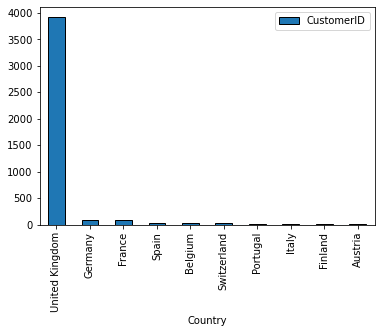

In [80]:
clients = data_clean[['CustomerID', 'Country']].drop_duplicates()
clients = clients.groupby(['Country']).count().sort_values(['CustomerID'], ascending=False).iloc[:10]
clients.plot.bar()

<AxesSubplot:xlabel='Country'>

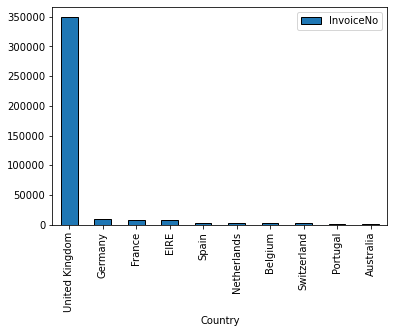

In [81]:
orders = data_clean[['InvoiceNo', 'Country']].groupby(['Country']).count().sort_values(['InvoiceNo'], ascending=False).iloc[:10]
orders.plot.bar()

In [82]:
# Create an attribute with total price
data_clean['TotalPrice'] =   data_clean['UnitPrice']* (data_clean['Quantity']- data_clean['QuantityCanceled'])
data_clean['TotalPrice'].mean()

21.126404167208413

<AxesSubplot:xlabel='Country'>

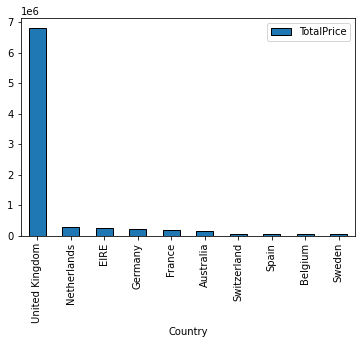

In [83]:
country_profits = data_clean[['TotalPrice', 'Country']].groupby(['Country']).sum().sort_values(['TotalPrice'], ascending=False).iloc[:10]
country_profits.plot.bar()

<AxesSubplot:xlabel='Month'>

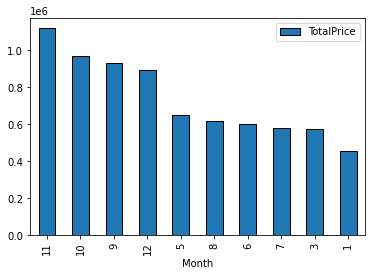

In [84]:
hour_profits = data_clean[['TotalPrice', 'Month']].groupby(['Month']).sum().sort_values(['TotalPrice'], ascending=False).iloc[:10]
hour_profits.plot.bar()

<AxesSubplot:xlabel='DayOfWeek'>

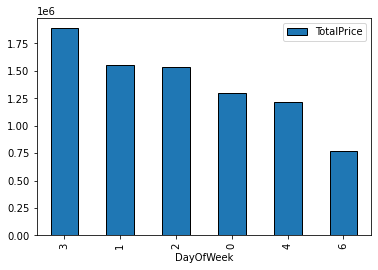

In [85]:
day_profits = data_clean[['TotalPrice', 'DayOfWeek']].groupby(['DayOfWeek']).sum().sort_values(['TotalPrice'], ascending=False).iloc[:10]
day_profits.plot.bar()

# RFM-Segmentation

The idea of RFM-segmentation is to group customers based on the following parameters:
* Recency - days from the last customer`s purchase;
* Frequency - the total number of customer`s purchases;
* Monetary Value - how much money the customer spent.


* Recency for the i-th customer is calculated as the difference between the date of the last order and the reference point, translated into days:
 $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$
where $t_{ij}$$ is the date on which the i-th customer makes his/her j-th purchase.

As a reference point $t_0$ we take a date 1 day "older" than all our data. It will be December 10, 2011 (in datetime format it will be '2011-12-10').

* Frequency is calculated as the total number of unique orders made by the i-th customer.
* Monetary Value is calculated as the total amount of money that the i-th customer spent on our products (accounting for the returns).


In [86]:
now = pd.to_datetime('2011-12-10')
custom_aggregation = {
    'InvoiceDate':  lambda x: (now - x.max()).days,
    'InvoiceNo': lambda x: len(x.unique()),
    'TotalPrice': lambda x: x.sum(),
}

rfm_table = data_clean.groupby('CustomerID').agg(custom_aggregation)

rfm_table = rfm_table.rename(
    columns={'InvoiceDate': 'Recency', 
             'InvoiceNo': 'Frequency', 
             'TotalPrice': 'Monetary'}
)

In [87]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_1.html')
fig.show()

There are some extreme values which should be dropped.

Remove from the RFM table the records of the customers for whom at least one of the conditions is met:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

where $frequency_{0.95}$ and $monetary_{0.95}$ are quantiles of the 0.95 level for the corresponding features. 

In [88]:
h_cap_monetary = rfm_table['Monetary'].quantile(0.95)
h_cap_frequency = rfm_table['Frequency'].quantile(0.95)

outliers = rfm_table[
    (rfm_table['Monetary'] > h_cap_monetary) | 
    (rfm_table['Frequency'] > h_cap_frequency) 
]
rfm_table_cleaned = rfm_table.drop(outliers.index)
print('RFM table shape: {}'.format(rfm_table_cleaned.shape))

RFM table shape: (4044, 3)


In [89]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

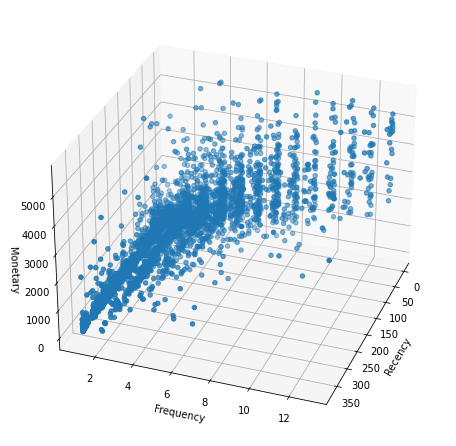

In [90]:
# 3D visualization
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


## PCA

First, we reduce dimensions and then segment into clusters.

In [91]:
# Pipeline with standardization and PCA decomposition
pipeline_1 = Pipeline([('ss', preprocessing.StandardScaler()), 
                      ('pca', decomposition.PCA(n_components=2))] )

rfm_table_processed = pd.DataFrame(pipeline_1.fit_transform(rfm_table_cleaned), columns= ['axis-1', 'axis-2'])

In [92]:
print('Share of variation explained by the 1st component: ', round(pipeline_1['pca'].explained_variance_ratio_[0], 2))

Share of variation explained by the 1st component:  0.68


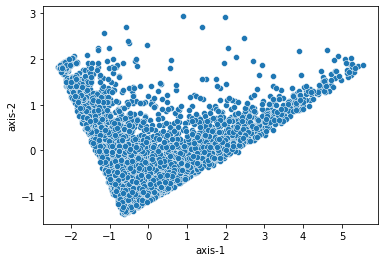

In [93]:
# isualization of components
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

### KMeans

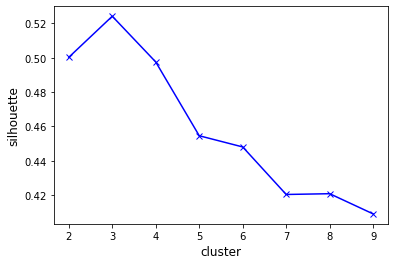

In [94]:
# Clustering using KMeans

# Define function to calculate silhouette score
def get_silhouette( cluster_num,   X, random = 42):
    k_means =  KMeans(n_clusters=cluster_num, random_state=random)
    k_means.fit(X)
    silhouette = silhouette_score(X, k_means.labels_)
    return silhouette

silhouette = []

# KMeans clustering with 2 - 10 clustes. Append list "silhouette" with silhouette score.
for i in range(2,10):
    silhouette.append(get_silhouette(i, rfm_table_processed))
# Plot silhouette scores.
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 10)], silhouette, 'xb-')

In [95]:
print(np.max(silhouette) )

0.5242296656541482


Best KMeans clustering is with 3 clusters. 

### EM

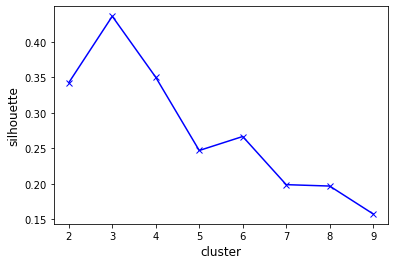

In [96]:
def get_silhouette( cluster_num,   X, random = 42):
    model =  GaussianMixture(n_components=cluster_num, random_state=random)
    model.fit(X)
    silhouette = silhouette_score(X, model.fit_predict(X))
    return silhouette

silhouette = []

for i in range(2,10):
    silhouette.append(get_silhouette(i, rfm_table_processed))

plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 10)], silhouette, 'xb-')

In [97]:
print(np.max(silhouette) )

0.4360614977265811


Best EM: 3 clusters.
KMeans outperformed EM. 

In [98]:
# KMeans was a better algorithm
model = KMeans(n_clusters= 3, random_state=42)
model.fit(rfm_table_processed )
labels = pd.Series(model.labels_)

labels.value_counts()

2    2269
0     999
1     776
dtype: int64

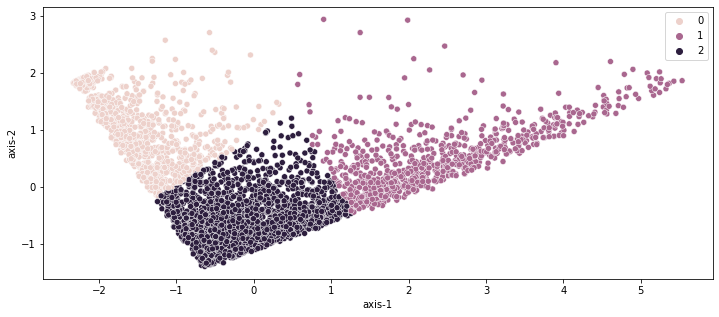

In [99]:
# Visualization of KMeans clustering on 2 components from PCA
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
);

In [100]:
# Descriptive stats by cluster
labels.index = rfm_table_cleaned.index
labels_rfm_table = rfm_table_cleaned
labels_rfm_table['labels'] = labels
grouped_stats = labels_rfm_table.groupby(['labels']).mean()
grouped_stats

,Recency,Frequency,Monetary
labels,,,
0,253.474474,1.403403,386.277297
1,31.943299,7.068299,2657.746997
2,51.221684,2.329220,660.068947


Visualize cluster profile using Radar Chart.

In [101]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Normalize the data to range between 0 and 1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Create list of features
    features = grouped_data.columns
    # Create empty figure
    fig = go.Figure()
    # Visualize for each cluster
    for i in range(n_clusters):
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, 
            theta=features, 
            fill='toself', 
            name=f'Cluster {i}', 
        ))
    # Update figure patameters
    fig.update_layout(
        showlegend=True, 
        autosize=False, 
        width=400, 
        height=400, 
    )
    fig.show()
    

In [102]:
plot_cluster_profile(grouped_stats,3 )

## tSNE

3 clusters is too few. It would be better to have more categories of customers for a more personalized approach. We try to improve algorithm. PCA is linear transformation. Now we try non linear transformation, namely, tSNE.

In [103]:
pipeline_2 = Pipeline([('ss', preprocessing.StandardScaler()), 
                      ('pca', TSNE(n_components = 2, perplexity=50, random_state=100))] )

rfm_table_processed = pd.DataFrame(pipeline_2.fit_transform(rfm_table_cleaned), columns= ['axis-1', 'axis-2'])


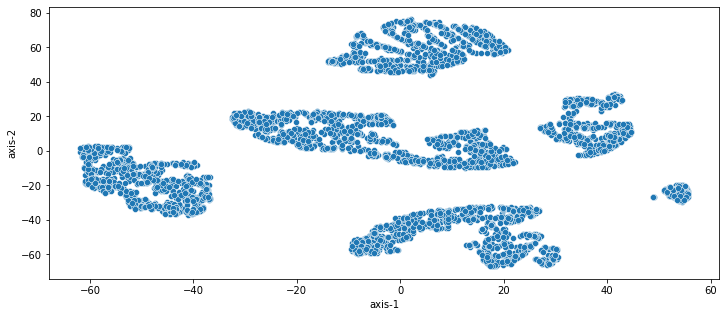

In [104]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

### EM

0.59


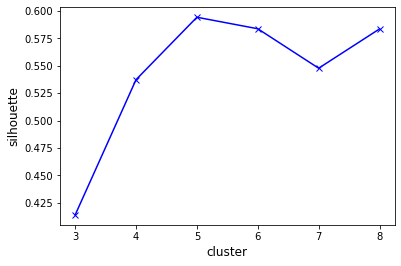

In [105]:
from sklearn.mixture import GaussianMixture

def get_silhouette( cluster_num,   X, random = 42):
    model =  GaussianMixture(n_components=cluster_num, random_state=random)
    model.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, model.fit_predict(X))
    return silhouette

em = []

for i in range(3,9):
    em.append(get_silhouette(i, rfm_table_processed))

plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(3, 9)], em, 'xb-')

print(round(max(em), 2))

### Agglomerative Clustering

0.61


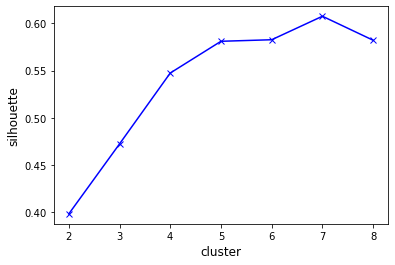

In [106]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# ss = preprocessing.StandardScaler()
# rfm_table_cleaned_scaled = ss.fit_transform(rfm_table_cleaned)

def get_silhouette( cluster_num,   X):
    k_means =  AgglomerativeClustering(n_clusters=cluster_num)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.labels_)
    return silhouette

silhouette = []

for i in range(2,9):
    silhouette.append(get_silhouette(i, rfm_table_processed))

plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 9)], silhouette, 'xb-')

print(round(max(silhouette), 2))

In [107]:
# The best algorithm was AgglomerativeClustering(n_clusters= 7)
model = AgglomerativeClustering(n_clusters= 7)
model.fit(rfm_table_processed)
labels = pd.Series(model.labels_)
labels.value_counts()

0    885
1    776
2    762
4    621
3    455
5    431
6    114
dtype: int64

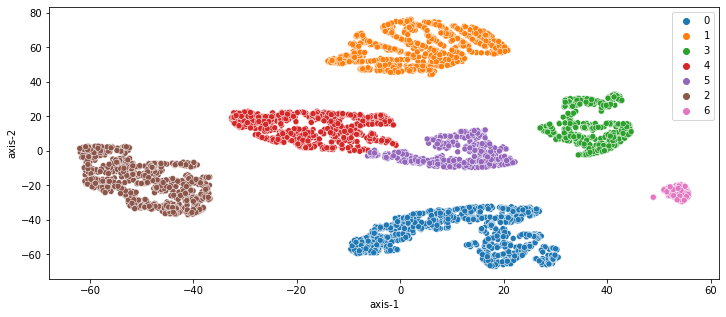

In [108]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=model.labels_.astype('str'));

In [109]:
# Descriptive stats by cluster
labels.index = rfm_table_cleaned.index
labels_rfm_table = rfm_table_cleaned
labels_rfm_table['labels'] = labels
grouped_stats = labels_rfm_table.groupby(['labels']).mean()
grouped_stats.round()

,Recency,Frequency,Monetary
labels,,,
0,239.0,1.0,406.0
1,32.0,7.0,2658.0
2,57.0,1.0,320.0
3,41.0,4.0,1021.0
4,52.0,2.0,640.0
5,50.0,3.0,908.0
6,365.0,1.0,236.0


In [110]:
plot_cluster_profile(grouped_stats,7)

From the Radar Chart above, we can infer that:
- cluster 0 corresponds to about to sleep
- cluster 1 corresponds to loyal customers
- cluster 2 corresponds to promising customers
- cluster 3 corresponds to at price sensitive
- cluster 4 corresponds to recent customers
- cluster 5 corresponds to potential loyalists
- cluster 6 corresponds to lost customers

# Classification problem

First, we try Random Forest, then Gradient Boosting (both tuned using GridSearch)and will compare the results using accuracy score. 

## Random Forest

In [112]:
rfm_table_cleaned.drop(columns=['labels'], inplace= True)
X = rfm_table_cleaned
# Split sample into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state= 42)
y_test.shape

(809,)

In [113]:
# Grid search with 5 folds of hyperparameters for RF
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

grid_search_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid= param_grid, 
             verbose=1,
             cv = 5)

grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 500}

In [118]:
clf = RandomForestClassifier(max_depth= 14, 
                             criterion=  'entropy', 
                             n_estimators= 500, 
                             random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
round(accuracy_score(y_test, y_pred), 3)

0.99

## Gradient Boosting

In [115]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
grid_search_cv = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
             param_grid= param_grid, 
             verbose=1,
             cv = 5)

grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

In [117]:
clf = GradientBoostingClassifier(max_depth= 3, 
                             learning_rate =  0.1, 
                             n_estimators= 500, 
                             random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
round(accuracy_score(y_test, y_pred), 3)

0.985

Random Forest performed slightly better than GB.